In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import ETTh1Dataset

In [6]:
series = ETTh1Dataset().load()

In [7]:
train, test = series[:-96], series[-96:]

In [8]:
from darts.models.forecasting.tide_model import TiDEModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)
scaled_train = scaled_train.astype(np.float32)  # or: .astype(np.float32, copy=False)


tide = TiDEModel(
    input_chunk_length=720, 
    output_chunk_length=96,
    num_encoder_layers=2,
    num_decoder_layers=2,
    decoder_output_dim=32,
    hidden_size=512,
    temporal_decoder_hidden=16,
    use_layer_norm=True,
    dropout=0.5,
    random_state=42)

tide.fit(
    scaled_train,
    epochs=30
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 6.2 M  | train
6 | decoders         | Sequential       | 4.2 M  | train
7 | temporal_decoder | _ResidualBlock   | 892    | train
8 | lookback_skip    | Linear           | 69.2 K | train
--------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.978    Total estimated model params size (MB)
48        Modules in train mode
0         Modules in eval 

Epoch 29: 100%|██████████| 516/516 [00:09<00:00, 51.61it/s, train_loss=0.00499]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 516/516 [00:10<00:00, 51.60it/s, train_loss=0.00499]


TiDEModel(output_chunk_shift=0, num_encoder_layers=2, num_decoder_layers=2, decoder_output_dim=32, hidden_size=512, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=16, use_layer_norm=True, dropout=0.5, use_static_covariates=True, input_chunk_length=720, output_chunk_length=96, random_state=42)

In [9]:
scaled_pred_tide = tide.predict(n=96)

pred_tide = train_scaler.inverse_transform(scaled_pred_tide)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.88it/s]


In [10]:
preds_df = pred_tide.pd_dataframe()
test_df = test.pd_dataframe()

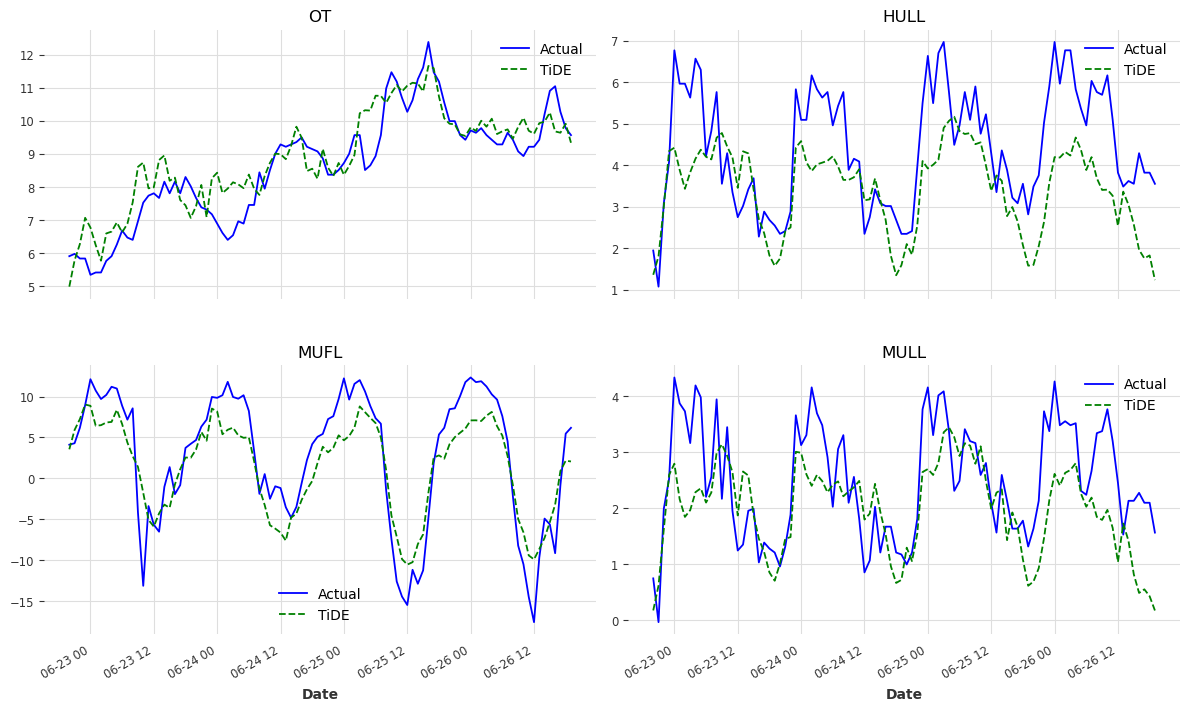

In [11]:
cols_to_plot = ['OT', 'HULL', 'MUFL', 'MULL']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

for i, ax in enumerate(axes.flatten()):
    col = cols_to_plot[i]
        
    ax.plot(test_df[col], label='Actual', ls='-', color='blue')
    ax.plot(preds_df[col], label='TiDE', ls='--', color='green')
    
    ax.legend(loc='best')
    ax.set_xlabel('Date')
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

In [12]:
from darts.metrics import mae, mse

tide_mae = mae(test, pred_tide)
tide_mse = mse(test, pred_tide)

print(tide_mae, tide_mse)

1.3863345621696987 4.63685989872065


In [13]:
data = {'TiDE': 
            [tide_mae, 
             tide_mse],
       'TSMixer': 
            [1.611139, 
             5.231349]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,TiDE,TSMixer
mae,1.386335,1.611139
mse,4.636860,5.231349
